# SIPs Absorption with Changing k

## 8/3/17

## Introduction 

We will build a rigorous model for absorption into SIPs, which accounts for changes in $k$ over time and space. However, it will still make assumptions. In particular, I'm yet to account for diffusion of gas through the solvent phase.

## Differential Equations

As derived previously, the differential equation governing flow into a flat surface of SIP is:

$$
\frac{\partial c}{\partial t}  = \mathcal{D}' \frac{\partial^2 c}{\partial x^2} -  \kappa(t,x)c
$$

with BC's 
$$c|_{x=\delta} = p_0S_{poly}$$ 
and 
$$\partial_x c|_{x=0} = 0.$$

In this equation:

$$
\mathcal{D}' = \mathcal{D}_{poly}\varepsilon \Bigg/\left( \varepsilon +  (1-\varepsilon) \frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}} \right)
$$

and 

$$
\kappa(t,x) = k(t,x)\frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}}(1-\varepsilon)\Bigg/ \left( \varepsilon +  (1-\varepsilon) \frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}} \right)
$$

We see that the first-order reaction rate inside the solvent droplets, $k$, changes in both time and space. Typically it decreases as more gas reacts with the solvent, with the rate of decrease a function of the rate of reaction:

$$
\frac{\partial k}{\partial t} = f(kc)
$$

Note that $f(\cdot)$ relates changes in the *loading* of the solvent to changes in the reaction rate. It's almost impossible to imagine an analytical solution to these equations, even in the simplest (and most common case), where $k_t \propto -kc$. The two functions that change in time and space, $k$ and $c$, are coupled in a horribly non-linear way. The one plausible approach would be to say that $k$ changes slowly, and the system is always in a quasi-steady state where $c_t \approx 0$. But even in that case, how do you solve $0 = c_{xx} - g(x)c$? Especially given that $g(\cdot)$ is not something constant, but changes as $k$ changes according to the ODE above. That said, this simplification could allow us to solve an ODE instead of a PDE - not something to be sniffed at. My one question is: does such a PDE actually converge to a steady-state solution, as it does when $g \equiv 1$? And if so, how quickly does this happen? I'm going to do some numerical experiments to find out.

The simplest way to do this is in arb. 

Arb experiments are back: it looks like, provided $k$ remains positive, the steady-state solution, if it exists, will be stable. Let's consider this. Imagine that $c^*$ solves

$$
0 = c^*_{xx} - k(x)c^*
$$

Then let say we add some noise, so consider $c^*(x) + \delta(t) = c^*(x) + \delta e^{i\lambda x}$. Then the pde will adjust this so that

$$
\frac{\partial (\delta(x))}{\partial t} = -(\lambda^2  +k(x)) \delta (x)
$$

Any deviation from the equilibrium function $c^*(x)$ can be expressed as a Fourier sum of such $\delta(x)$'s with various values of $\lambda$. And we see that the system acts to squash such changes, provided $k>0$. As $k>0$ is always going to hold, a numerical solution assuming $k(t,x) \approx k(x)$ and $c_t \approx 0$ at each time-step should be reasonable. The logic holds provided that $k$ changes at a rate much slower than $c$ takes to adjust. Now, $k$ changes because the solvent loading changes - this is a slow process. Meanwhile, $c$ takes on the order of $1/\kappa$ to adjust - in more conventional systems, on the order of $1/k$. This is the typical time for the system to go from saturated in *gas* to only maybe half-saturated. In that time, for most solvents $k$ won't really change at all. So this seems a very reasonable assumption. We're really comparing the amount of gas dissolved phsyically to the amount of gas dissolved chemically. This assumption would only break if $\mathcal{S}_{poly}$ was extremely high, to make it comparable with the liquid loading (a few mol/L). This is not the case. Thus, it's reasonable to treat $k$ as constant for long enough for $c$ to reach the pseudo-steady state distribution. 

In conclusion, we are solving two coupled pde's:

$$
\frac{\partial c}{\partial t}  = \mathcal{D}' \frac{\partial^2 c}{\partial x^2} -  \kappa(x; t)c
$$
with

$$
\mathcal{D}' = \mathcal{D}_{poly}\varepsilon \Bigg/\left( \varepsilon +  (1-\varepsilon) \frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}} \right)
$$

and 

$$
\kappa(x; t) = k(x; t)\frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}}(1-\varepsilon)\Bigg/ \left( \varepsilon +  (1-\varepsilon) \frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}} \right)
$$

The second PDE is

$$
\frac{\partial k(x; t)}{\partial t} = f(k(x; t)c)
$$

We will do this by progressively solving for 

$$
0  = \mathcal{D}' \frac{\partial^2 c}{\partial x^2} -  \kappa(x; t)c
$$

And then adjust $k$ at each time-step via

$$
\frac{\partial k(x; t)}{\partial t} = f(k(x; t)c)
$$

I'm going to use ApproxFun to solve this with Chebyshev polynomials. I will want to build this as a general function. My function will require a Chebyshev approximation to $k(x;t)$, along with all of the other phyiscal constants. It will then solve for $c(x)$. I will then make a second function that adjusts $k$ for a given $\Delta t$. I can than run these in sync to solve this system over time.

To simplify matters, we will multiply the PDE through by $1/\mathcal{D}'$. It then becomes

$$
0  = \frac{\partial^2 c}{\partial x^2} -  \kappa'(x; t)c
$$

where

$$
\kappa' = \frac{\kappa}{\mathcal{D}'} =  k(x; t)\frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}}(1-\varepsilon)\Bigg/ \mathcal{D}_{poly} \varepsilon = \frac{(1-\varepsilon) \mathcal{S}_{solv}}{\varepsilon \mathcal{P}_{poly}}k(x; t)
$$

In [3]:
using ApproxFun     #use Chebychev Polynomial approximation package.

function SolveForConcentrationProfile(k,P_poly,S_sol,ɛ,S_poly,p_0,R)
    r = Fun(0..R)                                                   #Define Identity Function on Interval  
    c0 = 0.0r                                                       #Define Initial Guess Function on Interval
    κ = Fun(r -> ((1-ɛ)*S_sol*k(r)) / (ɛ*(P_poly)), 0..δ)           #Define κ function in ODE
    N = u -> [u'(0.0); u(R) - p_0*S_poly; 1/r*(r*u')' - κ(r)*u]             #Define the ODE BVP problem
    c = newton(N,c0)                                                #Solve the ODE BVP Problem.
    return c
end


SolveForConcentrationProfile (generic function with 1 method)

(Any, Any, Any, Any, Any, Any, Any) in module Main at In[1]:4 overwritten at In[3]:4.


### Testing this function with a known solution.

We know that for $k(x) = k$, the solution is:


$$
c = \mathcal{S}_{\text{poly}} p_0 \frac{\cosh(\phi x/\delta)}{\cosh(\phi)}
$$

where

$$
\phi^2 = \delta^2\frac{k'}{\mathcal{D}'} = \delta^2 k\frac{\mathcal{S}_{solv}}{\mathcal{S}_{poly}}(1-\varepsilon) \Bigg/\mathcal{D}_{poly}\varepsilon = \delta^2 \frac{(1-\varepsilon)k\mathcal{S}_{solv}}{\varepsilon\mathcal{P}_{poly}}$$

We'll now see if our function comes to the same solution. We'll pick some very simple values for this experiment.

In [9]:
using Plots
(kvalue, P_poly,S_sol,ɛ,S_poly,p_0,R) = (1.0,1.0,1.0,0.5,1.0,1.0,1.0);
k = Fun(x -> kvalue, 0..R);
u_numerical = SolveForConcentrationProfile(k,P_poly,S_sol,ɛ,S_poly,p_0,R)

#Now do analytical calculation
ϕ = sqrt(R^2 * (1-ɛ)*kvalue*S_sol / (ɛ*P_poly));
u_analytical  = Fun( x -> S_poly * p_0 * cosh(ϕ*x/δ)/cosh(ϕ), 0..δ)
println("The Maximum Difference Between the Numerical and Analytical Results was ", norm(u_numerical - u_analytical))
plot(u_numerical)

The Maximum Difference Between the Numerical and Analytical Results was 0.10517713422080512


It is clear that the numerical model works well. We can now write the second part of the script - using this numerical calculated concentration profile to predict how quickly the solvent droplets get saturated over time at different points in space. This general function will spit out a modified $k(x; t+\Delta t)$ from an initial input $k(x; t)$. We will require, as input, a function $g$ which tells us the *concentration of reactive species* (e.g. $OH^-$ ions) as a function of the concentration of CO2 present in the solvent. Note that, while we are using $k$ as our second unknown function, it's perhaps more sensible to use the CO2 loading in mol/m3, $\xi$. In fact, let's do that. Our function below will take as input $\xi(x)$, along with some physical properties (including the second order rate constant) and it will spit out the new $\xi(x)$ and the new $k(x)$. We have, for a reaction-controlled droplet

$$
\frac{d \xi}{dt} = k_2 c_{sol}c_{\text{reactivespecies}}
$$
and so
$$
\frac{d \xi}{dt} = k_2\frac{\mathcal{S}_{sol}}{\mathcal{S}_{poly}}cg(\xi)
$$

where $g(\cdot)$ is as discussed above. Once we have evaluated $\xi_{t+\Delta t}$, we can evaluate the new $k$ as $k=k_2g(\xi_{t+\Delta t})$.

In [14]:
#This function will be solvent-dependent
function ConcentrationOfReactiveSpecies(ξ)
    A = 2.0                                  #Initialy 2 mols of reactive species, which...
    return 2.0 - ξ                           #CO2 binds with on a 1-1 stoichiometric basis
end

#This function will take as input a concentration profile ξ, a time step Δt, R, k2, S_sol, c, and the function g()
#and will spit out updated ξ and k functions.

function TimeStepLoadingAndReactionRateConstant(ξ, c, g, k2, S_sol, S_poly, R, Δt)
    ξ = ξ + Fun(r -> k2*S_sol/S_poly*c(r)*g(ξ(r)), 0..R)*Δt           #WRONG k2*
    k = Fun(r -> k2*g(ξ(r)), 0..R)
    return [ξ, k]
end

TimeStepLoadingAndReactionRateConstant (generic function with 1 method)

) in module Main at In[10]:3 overwritten at In[14]:3.


In [26]:
S_sol = 1.0
S_poly= 1.0
Δt = 0.01
k2 = 1.0
R = 1.0
ξ_old = Fun(r -> 0.8+0.3*sin(6*r), 0..R)
c_old = Fun(r -> 0.8+0.3*sin(6*r), 0..R)
(ξ,k) = TimeStepLoadingAndReactionRateConstant(ξ_old, c_old, ConcentrationOfReactiveSpecies, k2, S_sol, S_poly, R, Δt)

2-element Array{ApproxFun.Fun{ApproxFun.Chebyshev{ApproxFun.Segment{Float64}},Float64},1}:
 Fun(Chebyshev(【0.0,1.0】),[0.798161,-0.202275,-0.0411131,0.184287,0.0115334,-0.0255699,-0.00118105,0.00148655,9.08001e-5,-4.50083e-5  …  -1.38364e-9,1.04101e-9,5.35452e-11,-3.23918e-11,-1.51474e-12,8.03351e-13,3.40727e-14,-1.62608e-14,-6.27883e-16,2.74091e-16])
 Fun(Chebyshev(【0.0,1.0】),[1.20184,0.202275,0.0411131,-0.184287,-0.0115334,0.0255699,0.00118105,-0.00148655,-9.08001e-5,4.50083e-5  …  -1.75056e-8,2.5959e-8,1.38364e-9,-1.04101e-9,-5.35451e-11,3.23918e-11,1.51474e-12,-8.0333e-13,-3.40619e-14,1.62516e-14])      

In [7]:
using ApproxFun
using Plots
plot(ξ)

LoadError: UndefVarError: ξ not defined

We're now in a position to integrate our equations, to predict the rate of absorption of CO2 into a solid wall of SIP over time. The function I will create do to this will take as an input $\Delta t$, the 3 functions defined above, a function $p_0(t)$, an initial solvent loading $\xi_0(x)$, all necessary physical constants, and $t_{\text{max}}$.

In [29]:
function IntegrateAbsorptionIntoSIPOverTime(SolveForConcentrationProfile, ConcentrationOfReactiveSpecies, TimeStepLoadingAndReactionRateConstant, P_poly, S_sol, ɛ, S_poly, p_0func, ξ0, R, k2, Δt, tmax)
    tsteps = ceil(tmax/Δt)
    t = 0.0
    ξ = ξ0
    k = Fun(x -> k2*ConcentrationOfReactiveSpecies(ξ(x)), 0..R)
    c_store = []
    ξ_store = []
    k_store = []
    for i = 1:tsteps
        #Calculate new constants for this timestep.
        t += Δt                                                 #New time
        p_0 = p_0func(t)                                        #New external reactive gas pressure at this time

        #Calculate concentration profile for this timestep
        c = SolveForConcentrationProfile(k,P_poly,S_sol,ɛ,S_poly,p_0,R)
        
        #Calculate newly-updated ξ and k functions
        (ξ_prev,k_prev) = [ξ, k]
        (ξ, k) = TimeStepLoadingAndReactionRateConstant(ξ_prev, c, ConcentrationOfReactiveSpecies, k2, S_sol, S_poly, R, Δt)
        c_store = push!(c_store,c)
        ξ_store = push!(ξ_store,ξ)
        k_store = push!(k_store,k)
    end
    return [c_store, ξ_store, k_store]
end
        
        

IntegrateAbsorptionIntoSIPOverTime (generic function with 1 method)

Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any) in module Main at In[27]:2 overwritten at In[29]:2.


In [ ]:
(P_poly, S_sol, ɛ, S_poly, R, k2, Δt, tmax) = [0.1, 1.0, 0.5, 1.0, 1.0, 1.0, 1e-2, 3e1]
p_0func = Fun(t -> 1.0, 0..tmax)
ξ0 = Fun(x -> 0.0, 0..R)
@time (c_store, ξ_store, k_store) = IntegrateAbsorptionIntoSIPOverTime(SolveForConcentrationProfile, ConcentrationOfReactiveSpecies, TimeStepLoadingAndReactionRateConstant, P_poly, S_sol, ɛ, S_poly, p_0func, ξ0, R, k2, Δt, tmax)


In [31]:
using Plots
plot(c_store[10])
for i = 20:10:980
    plot!(c_store[i])
end
plot!(c_store[1000])

In [ ]:
#Find Total Flux Into Praticles
t = linspace(0,Δt*length(c_store), length(c_store))
n = zeros(length(c_store))
for i = 2:length(c_store)
    dcdr= c_store[i]'
    n[i] = n[i-1] + ɛ*P_poly/S_poly*dcdr(R)*Δt
end
plot(t,n)

In [ ]:
#Least Squares Fit
using LsqFit
model(t,param) = param[1]*(1 - exp(-param[2]*t))
xdata = linspace(0,Δt*length(c_store), length(c_store))
ydata = n
fit = curve_fit(model, xdata, ydata, [0.5, 0.5])
fit.param
p = plot(t,n)
#plot(t,fit.param[1]*(1 - exp(-fit.param[2]*t)))
plot!(t,fit.param[1]*(1 - exp(-fit.param[2]*t)))
#plot(t,fit.param[1]*(1 - exp(-fit.param[2]*t)))

## Adding Monolith Model 

For a monolith containing ideal gas and a (dilute) species being absorbed, and ignoring axial diffusion, we have
 - Build up of dilute gas inside unit area and thin size of monolith is
 
 $$
 \frac{1}{RT}\frac{\partial p}{\partial t}\Bigg|_z \left(1 - \frac{4(w-\delta)\delta}{w^2}\right)\Delta z 
 $$
 
 - Net *flow* of gas into boundaries of shell (ignoring axial diffusion) is
 
 $$
 \frac{u}{RT}(p_z - p_{z+\Delta z})
 $$

 - Net flow of gas from the gas into the SIP is
 
 $$
 \mathcal{J}(\xi(x),p) \frac{4(w-2\delta)}{w^2} \Delta z 
 $$

Overall, then, we have

$$
\frac{1}{RT}\frac{\partial p}{\partial t}\Bigg|_z \left(1 - \frac{4(w-\delta)\delta}{w^2}\right) = -\frac{u}{RT}\frac{dp}{dz} - \mathcal{J}(\xi(x),p) \frac{4(w-2\delta)}{w^2} 
$$

To solve this, we'll integrate each point over time, keeping track of the concentration profiles in the SIP as we go. We'll modify SolveForConcentrationProfile so that it takes $\xi$ rather than $k$ as its input. We can do this, as we have

$$
k = k_2 g(\xi)
$$

Our boundary conditions will be 

$$
p_{z = 0} = p_{inlet}
$$

and (reluctantly)

$$
\frac{dp}{dz}\Bigg|_{z=L} = 0
$$

We will discretize this in space, but can then send it to a sophisticated time-integrator, if such exist in Julia...

In [132]:
function SolveForConcentrationProfileXi(ξ,g,c0,k2,P_poly,S_sol,ɛ,S_poly,p_0,δ)
    k = Fun(x ->k2*g(ξ(x)),0..δ)                                     #         
    x = Fun(0..δ)                                                   #Define Identity Function on Interval  
    κ = Fun(x -> ((1-ɛ)*S_sol*k(x)) / (ɛ*(P_poly)), 0..δ)           #Define κ function in ODE
    N = u -> [u'(0.0); u(δ) - p_0*S_poly; u'' - κ(x)*u]             #Define the ODE BVP problem
    c = newton(N,c0)                                                #Solve the ODE BVP Problem.
    return c
end

function FluxToSIP(ξ,g,c0,k2,P_poly,S_sol,ɛ,S_poly,p_0,δ)
    k = Fun(x ->k2*g(ξ(x)),0..δ)                                     #         
    x = Fun(0..δ)                                                   #Define Identity Function on Interval  
    κ = Fun(x -> ((1-ɛ)*S_sol*k(x)) / (ɛ*(P_poly)), 0..δ)           #Define κ function in ODE
    N = u -> [u'(0.0); u(δ) - p_0*S_poly; u'' - κ(x)*u]             #Define the ODE BVP problem
    c = newton(N,c0)                                                #Solve the ODE BVP Problem.
    dcdx = Fun(c',0..δ)
    return [dcdx(δ)*ɛ*P_poly/S_poly, c]
end
gg = Fun(c', 0..δ)

Fun(Chebyshev(【0.0,1.0】),[1.0758,1.44152,0.476303,0.130041,0.0229125,0.00386371,0.000460956,5.60416e-5,5.0448e-6,4.79007e-7  …  2.69362e-9,1.62396e-10,1.07122e-11,5.54131e-13,3.17047e-14,1.43601e-15,7.25361e-17,2.91214e-18,1.31904e-19,-4.78403e-21])

In [136]:
(P_poly, S_sol, ɛ, S_poly, δ, k2, Δt, tmax) = [0.1, 1.0, 0.5, 1.0, 1.0, 1.0, 1e-2, 1e1]
ξ = Fun(x -> 1.0, 0..δ)
g = ConcentrationOfReactiveSpecies
c0 = Fun(x -> 0.0, 0..δ)
@time c = SolveForConcentrationProfileXi(ξ,g,c0,k2,P_poly,S_sol,ɛ,S_poly,p_0,δ)
@time (flux,c) = FluxToSIP(ξ,g,c,k2,P_poly,S_sol,ɛ,S_poly,p_0,δ)

  0.089419 seconds (125.14 k allocations: 5.405 MB)
  0.047783 seconds (70.95 k allocations: 3.080 MB)


2-element Array{ApproxFun.Fun{ApproxFun.Chebyshev{ApproxFun.Segment{Float64}},Float64},1}:
 Fun(Chebyshev(【NaN,NaN】),[0.157548])                                                                                                                                                                                                                          
 Fun(Chebyshev(【0.0,1.0】),[0.370272,0.418825,0.163935,0.0377825,0.00788607,0.00112258,0.000158653,1.62825e-5,1.73633e-6,1.39172e-7  …  1.00561e-18,3.8381e-20,1.64881e-21,5.69529e-23,2.22477e-24,7.01808e-26,2.51353e-27,7.29587e-29,2.41239e-30,-6.4845e-32])

In [98]:
dcdx = Fun(c', 0..δ)
dcdx(δ)*ɛ*P_poly/S_poly


0.15754829125650002

In [137]:
function MonolithIntegrator(tmax,Δt,p0_func,p_inlet,u,R,T,J,g,ξ_store0,cprev_store0,k2,P_poly,S_sol,ɛ,S_poly,δ,w)
    L = 100
    Δz = 0.1
    ξ_store = ξ_store0
    cprev_store = c_store0
    npoints = L/Δz
    tpoints = tmax/Δt
    zvals=linspace(0,L,npoints+1)
    p = p0_func(zvals)
    pstore = []
    for i = 1:tpoints
        dpdt = zeros(npoints)
        ξ_new = zeros(npoints)
        for i = 1:npoints
            if i == 1
                p[i] = 1
            elseif i <= npoints-1
            ξ_prev = ξ_store[i]
            c0guess = cprev_store[i]
            p0 = p[i]
            (J, c) = FluxToSIP(ξ_prev,g,c0guess,k2,P_poly,S_sol,ɛ,S_poly,p_0,δ)
            dpdt[i] = (1 - 4*(w-δ)*δ/w^2)^-1 * (-u*(p[i+1]-p[i-1])/(2Δz) - J*4*(w-δ)/w^2 * 1/(R*T))
            (ξ_new[i], k) = TimeStepLoadingAndReactionRateConstant(ξ, c, g, k2, S_sol, S_poly, δ, Δt)
            elseif i == npoints
                p[i] == [[i-1]]
            end
        end
        p += dpdt*Δt
        ξ_store = ξ_new
        pstore = push!(pstore,p)
    end
end

MonolithIntegrator (generic function with 1 method)


$$
\frac{\partial p}{\partial t} = -u\frac{dp}{dz}\left(1 - \frac{4(w-\delta)\delta}{w^2}\right)^{-1} - \mathcal{J}(\xi(x),p) \frac{4(w-2\delta)}{w^2} \frac{1}{RT}\left(1 - \frac{4(w-\delta)\delta}{w^2}\right)^{-1}
$$


In [100]:
a = Fun(x -> sin(x), 0..π)

Fun(Chebyshev(【0.0,3.141592653589793】),[0.472001,6.68769e-17,-0.499403,-1.73084e-17,0.0279921,-1.55855e-17,-0.000596695,1.43174e-17,6.70439e-6,-1.45704e-17,-4.65323e-8,-4.62105e-17,2.19346e-10,-4.59067e-17,-7.48185e-13])

In [110]:
a = Fun(x -> sin(x), 0..π)
avals = a(linspace(0,1,1000));

In [125]:
tic()
avals *= 3
toc()


elapsed time: 0.000291805 seconds


0.000291805

In [127]:
L = 100
Δx = 0.1
npoints = L/Δx
linspace(0,L,npoints+1)

1001-element LinSpace{Float64}:
 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,…,99.4,99.5,99.6,99.7,99.8,99.9,100.0

## Experiments with ApproxFun

The simplest and most elegant way of solving these boundary value problems in Julia is to use Chebychev polynomials as approximating functions, via the ApproxFun.jl package. Below we'll solve the simplified system:

$$
0 = \ddot{y} - k(t)y
$$

with BCs $y(0) = 0$ and $\dot{y}(1) = 0$, for various $k(t)$. I suspect that when we non-dimensionalise our model, this will be the type of equation we'll be solving for. 

In [11]:
using ApproxFun
using Plots

#Define a κ function
κ = Fun(t->1, 0..1)
t = Fun(identity, 0..1)
y = [Evaluation(Chebyshev(),0); Evaluation(Chebyshev(),1)*𝒟; 𝒟^2 - t] \ [0; 0; 0]

LoadError: Domain mismatch: cannot multiply function on 【0.0,1.0】 to function on 【-1.0,1.0】

In [12]:
b = Fun(cos,Fourier())
c = 0.1; u = (𝒟+c*I)\b;
u(0.6)

0.64076835137228

In [13]:
t = Fun(0..1)
u = [Evaluation(0); 𝒟]  \ [1;0];
plot(u)

LoadError: Cannot infer spaces


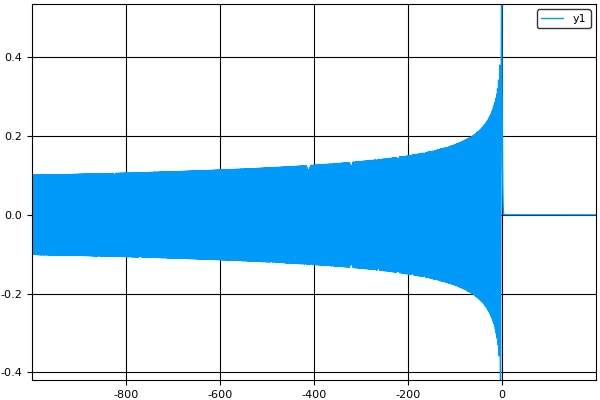

In [14]:
x = Fun(identity,-1000..200)
d = domain(x)
D = Derivative(d)
B = dirichlet(d)
L = D^2 - x
u = [B;L] \ [airyai(d.a);airyai(d.b);0]
plot(u)


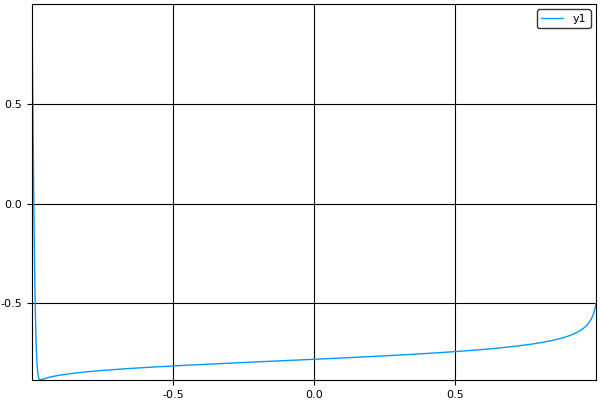

In [15]:
x=Fun()
u0=0.0x

N=u->[u(-1)-1,u(1)+0.5,0.001u''+6*(1-x^2)*u'+u^2-1]
u=newton(N,u0)
plot(u)


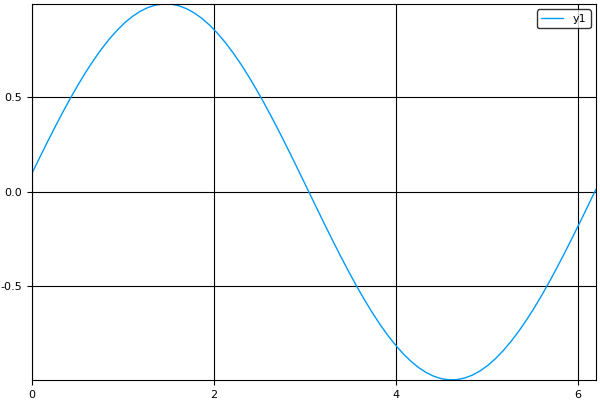

In [16]:
b = Fun(cos,Fourier());
c = 0.1; u = (𝒟+c*I)\b;
plot(u)


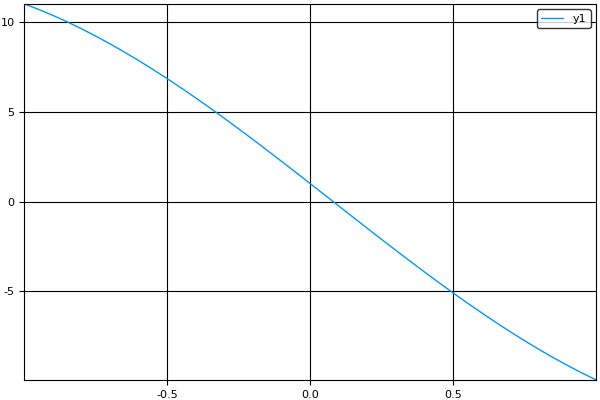

In [17]:
b = Fun(x->0,0..π);
c = 1; 
u = [Evaluation(Chebyshev(),0);Evaluation(Chebyshev(),π); (𝒟^2+I)]\[1;-1;b];
plot(u)

In [18]:
u(π)

0.0


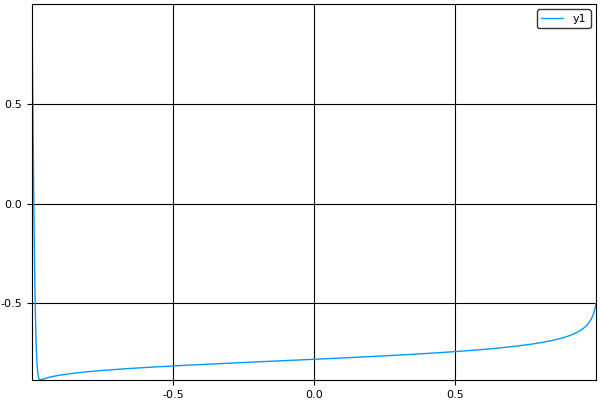

In [19]:
x=Fun()
u0=0.0x

N=u->[u(-1)-1,u(1)+0.5,0.001u''+6*(1-x^2)*u'+u^2-1]
u=newton(N,u0)
plot(u)

In [20]:
x=Fun(0..1)
u0=0.0x

N=u->[u(0)-1,u(1)+0.5,0.001u''+6*(1-x^2)*u'+u^2-1]
u=newton(N,u0)
plot(u)

LoadError: InterruptException:

In [21]:
2+3

5

In [22]:
using ApproxFun
x = Fun()
u0 = 0.0x
c = 1
ε = 0.01
N = u->[u(-1.)-c;u(1.);ε*u''+6*(1-x^2)*u'+u^2-1.]
u = newton(N,u0)

Fun(Chebyshev(【-1.0,1.0】),[-0.267222,0.0363803,0.217463,-0.134498,0.184769,-0.139881,0.147985,-0.115815,0.108359,-0.0829588  …  -4.41585e-34,1.52537e-34,2.33049e-35,-9.35795e-35,9.71181e-35,-6.68653e-35,3.03121e-35,-1.6621e-35,-7.10843e-36,-1.77636e-35])

In [23]:
u0

Fun(Chebyshev(【-1.0,1.0】),[0.0,0.0])


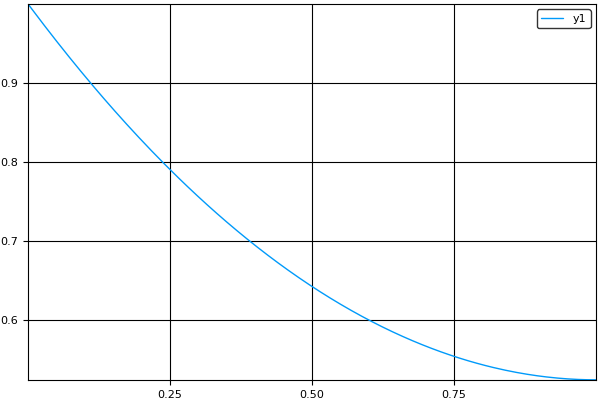

In [24]:
#It looks like the Newton Interface is significantly easier to use.

x = Fun(0..1)   #Our domain, expressed as an identity function.
u0 = 0.0x       #Our initial guess, expressed as the zero function over the same domain.
κ = Fun(x -> sin(x)+1,0..1)
N = u -> [u(0.0) - 1.0; u'(1.0) - 0.0; u'' - κ(x)*u]
#N = u -> [u(0.0) - 1.0; u'(1.0) - 0.0; u'' - κ(x)*u]
u = newton(N,u0)
plot(u)

In [25]:
using Plots

In [26]:
x = Fun(0..1)   #Our domain, expressed as an identity function.
u0 = 0.0x
κ = Fun(x -> 1.0)
N = u -> [u(0.0) - 1; u'(1.0) - 0.0; u'' - κ(x)*u]
tic()
u = newton(N,u0)

Fun(Chebyshev(【0.0,1.0】),[0.777154,-0.174181,0.0466317,-0.0017865,0.000240868,-5.5539e-6,5.00022e-7,-8.24327e-9,5.56956e-10,-7.14446e-12,3.86287e-13,-4.05513e-15,1.82741e-16,-1.62344e-18,6.27144e-20,-4.82898e-22,1.63239e-23,1.10912e-25])

In [27]:
tic()
function tester(nterms)
    a = 0.0
for i = 1:nterms
    a += i
end
    return a
end
a
u = toc()
a

LoadError: UndefVarError: a not defined

In [28]:
@time tester(5e8)

  3.371338 seconds (1.23 k allocations: 58.541 KB)


1.250000000671089e17

In [29]:
tic()
a = 0.0
for i = 1:5e8
    a += i
end
    return a
toc()

elapsed time: 17.705572744 seconds


17.705572744